## Project Report: Analysis of peoples interest in livestreams of published video games

**Name:** Kevin Kocev \
**Submit date:** 10th January 2024

### Introduction

Are popular published video games also popular livestream formats? The main question sounds trivial at first, but are popular video games also popular livestream formats? Particularly in view of the advertising impact of presenting video games on streaming platforms such as Twitch or YouTube, it could be interesting for game developers to ask themselves in advance whether a new game will also have a corresponding reach of streamers and viewers. The information could also be interesting for deciding whether to actively invest in streaming as an advertising channel in order to increase the reach of the game on the relevant platforms.

The aim of this data science project is to provide insights into the popularity of video games among players and viewers, and, if possible, to identify correlations by answering the research question. For this purpose, alongside the methodology, plots are presented for visualization to give an impression of the data. The results are interpreted in the conclusion/discussion with relation to the research question.

### Methods

#### Data sources

The following data sources are used for this project:

* Datasource 1: Top games on Twitch 2016 - 2023
  * Metadata URL: https://www.kaggle.com/datasets/rankirsh/evolution-of-top-games-on-twitch
  * Data URL: https://www.kaggle.com/datasets/rankirsh/evolution-of-top-games-on-twitch/download?datasetVersionNumber=16
  * Data Type: CSV

* Datasource 2: Popular Video Games
  * Metadata URL: https://www.kaggle.com/datasets/matheusfonsecachaves/popular-video-games
  * Data URL: https://www.kaggle.com/datasets/matheusfonsecachaves/popular-video-games/download?datasetVersionNumber=1
  * Data Type: CSV

Data source 1 contains the data on Twitch livestreams, such as the most popular games with hours watched and streamed, listed by month from 2016 to 2023. The data is used to analyze the performance of livestreams of different games. Data source 2, on the other hand, contains general data on successful video games, including platforms, genres and popularity. This data is used as metadata to expand Twitch's data and perform generalized analyses.

#### Data pipeline

As the data pipeline uses data from Kaggle and access is secured via API credentials, the access data for the API must be read in before the data pipeline can be executed. A bash script is used as an entry point for this, which performs the configuration.

The data pipeline can then be executed, whereby the following steps are performed individually for each data source:

1. First, the data is downloaded and unpacked directly, whereby if there are several datasets, only those that will be used for the subsequent analysis are kept. The data is then read in and, if necessary, corrections are made to the files beforehand to prevent problems during import.
2. After the data has been read in, it is prepared by selecting, transforming or converting it.
3. The prepared data is then stored in an SQLite database in a separate table.
4. Finally, the raw data files are deleted so that only the SQLite database remains.

After each individual data source has been processed, an additional table is created in the SQLite database, which contains the combination of the two data sources in order to be able to perform comprehensive analyses. In this specific case, metadata for the associated games is added to the Twitch data, if available.

#### Data cleaning/transformation

As mentioned in the section on the data pipeline, data is prepared before being stored. The following steps provide a closer look at these processes for each data source.

**Data Source 1: Top games on Twitch 2016 - 2023**

Columns that are not used for data analysis, such as Rank, Streamers, and Avg_viewer_ratio, are removed. Additionally, since Twitch allows streaming content unrelated to games, all categories that do not correspond to a game are removed.

**Data Source 2: Popular Video Games**

Similar to the first source, columns not utilized for later data analysis, such as Summary, Rating, or Reviews, are removed. Furthermore, the total plays of individual games are converted into numerical values, as thousands were abbreviated with "K". Platforms and Genres are also converted into comma-separated strings to simplify conversion into lists which ease the data analysis.

#### Problems

In the execution of Data Engineering, there were no fundamental issues. However, there were encoding problems with Data Source 1, causing certain UTF-8 characters to be incorrectly displayed, complicating the merging process with metadata from Data Source 2. After manual inspection, the focus was on the character é, which had to be replaced manually when using the Code Point representation.

Another issue is the absence of data. Despite the good quality of the two data sources, there are missing data that would have been helpful for a more in-depth analysis. For instance, sales data or active players on a monthly basis, as in Data Source 1, would have helped in illustrating monthly or yearly trends between games and streams. Even alternative data sources lacked such a data structure, leaving Web Scraping or APIs as the only alternative, which would have exceeded the project scope and not met the specified project conditions.

### Results

The data is presented graphically below to give an impression of the information and results.

#### Preparation

Steps that are necessary to work with the data.

##### Install dependencies

In [1]:
%pip install kaggle
%pip install pandas
%pip install sqlalchemy
%pip install matplotlib
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


##### Import modules

In [2]:
import os
import subprocess
import sys
import pandas as pd
import sqlalchemy as sa
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

##### Run data pipeline (if needed)

In [3]:
# Important: Set kaggle API credentials to use the data pipeline

# - - - KAGGLE SETUP START - - -
KAGGLE_USERNAME = ''
KAGGLE_KEY = ''
# - - - KAGGLE SETUP END - - -

In [4]:
# Run data pipeline if database doesn't exist
if not os.path.exists('../data/data.sqlite'):
    # Copy custom environment
    custom_env = os.environ.copy()

    # Check if kaggle credentials are set
    if (len(KAGGLE_USERNAME) <= 0 or len(KAGGLE_KEY) <= 0):
        print("You need to run the data pipeline but didn't set the kaggle API credentials", file=sys.stderr)

    # Update environment
    custom_env['KAGGLE_USERNAME'] = KAGGLE_USERNAME
    custom_env['KAGGLE_KEY'] = KAGGLE_KEY

    # Run subprocess with custom environment
    subprocess.run(['./pipeline.sh'], env=custom_env)

##### Load data

In [5]:
# Load data from SQLite database
con = sa.create_engine('sqlite:///../data/data.sqlite?charset=utf8')
df_tg = pd.read_sql_table('twitch_games', con)
df_pvg = pd.read_sql_table('popular_video_games', con)
df_merged = pd.read_sql_table('merged', con)

#### Data presentation

##### Video games by genre

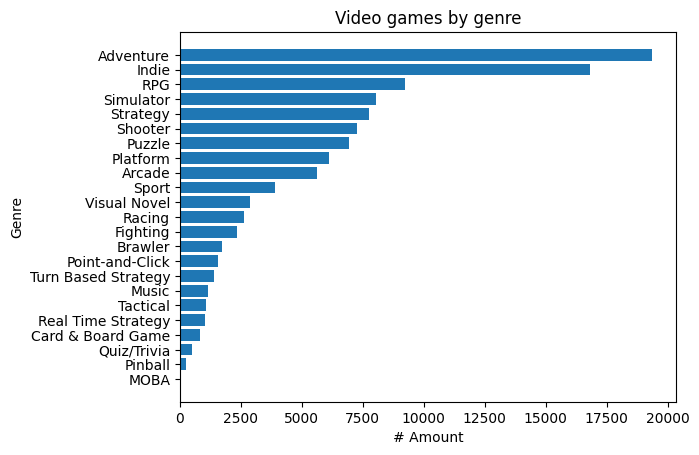

In [6]:
# Get genres of games
df_plot1 = df_pvg['Genres']
# Drop rows with NaN
df_plot1 = df_plot1.dropna()
# Convert values to list for usage with explode
df_plot1 = df_plot1.apply(lambda x: x.split(', '))
# Split values in single rows
df_plot1 = df_plot1.explode()

# Get values for all genres
genres_grouped = df_plot1.value_counts()

# Build plot
plt.title("Video games by genre")
plt.xlabel('# Amount')
plt.ylabel('Genre')
plt.barh(genres_grouped.index[::-1], genres_grouped[::-1])

# Show plot
plt.show()

##### Top 10 of most popular video games by plays

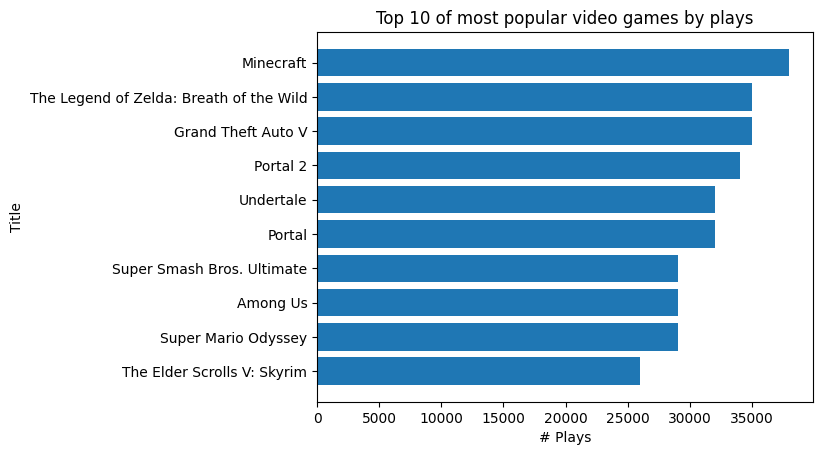

In [7]:
# Get top 10 of video games by plays
df_plot2 = df_pvg.sort_values(['Plays'], ascending=False).head(10)

# Build plot
plt.title("Top 10 of most popular video games by plays")
plt.xlabel('# Plays')
plt.ylabel('Title')
plt.barh(df_plot2['Title'][::-1], df_plot2['Plays'][::-1])

# Show plot
plt.show()

##### Video game genres by plays

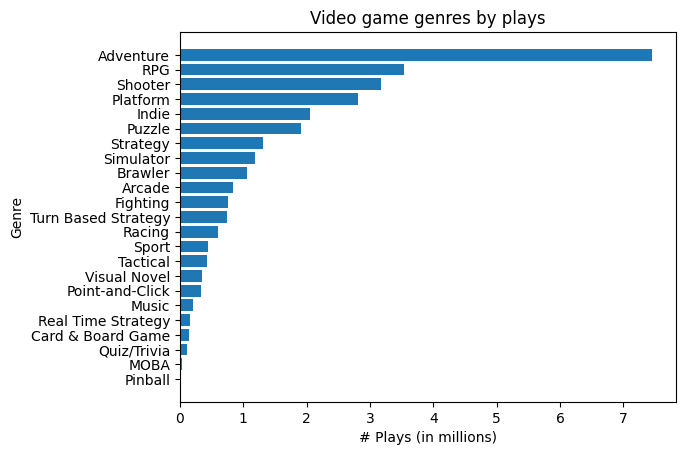

In [8]:
# Get columns
df_plot3 = df_pvg[['Genres', 'Plays']]
# Drop rows with NaN
df_plot3 = df_plot3.dropna()
# Convert values to list for usage with explode
df_plot3['Genres'] = df_plot3['Genres'].apply(lambda x: x.split(', '))
# Split values in single rows
df_plot3 = df_plot3.explode('Genres')

# Group genres, sum plays and sort them
genres_grouped = df_plot3.groupby('Genres').sum()
genres_grouped = genres_grouped.sort_values('Plays', ascending=False)

# Convert plays in smaller values for better plot
genres_grouped['Plays'] = genres_grouped['Plays'] / 1000000

# Build plot
plt.title("Video game genres by plays")
plt.xlabel('# Plays (in millions)')
plt.ylabel('Genre')
plt.barh(genres_grouped.index[::-1], genres_grouped['Plays'][::-1])

# Show plot
plt.show()

##### Top 10 most famous games by hours watched

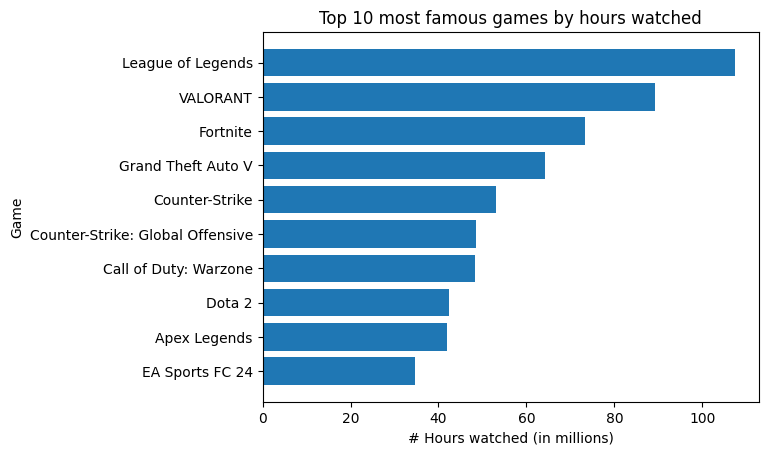

In [9]:
# Get games and watched hours
df_plot4 = df_tg[['Game', 'Hours_watched']]

# Group games, calculate average watched hours and sort appearances
df_plot4 = df_plot4.groupby('Game').mean()
df_plot4 = df_plot4.sort_values('Hours_watched', ascending=False).head(10)

# Convert watched hours in smaller values for better plot
df_plot4['Hours_watched'] = df_plot4['Hours_watched'] / 1000000

# Build plot
plt.title("Top 10 most famous games by hours watched")
plt.xlabel('# Hours watched (in millions)')
plt.ylabel('Game')
plt.barh(df_plot4.index[::-1], df_plot4['Hours_watched'].values[::-1])

# Show plot
plt.show()

##### Twitch streamed and watched hours per year

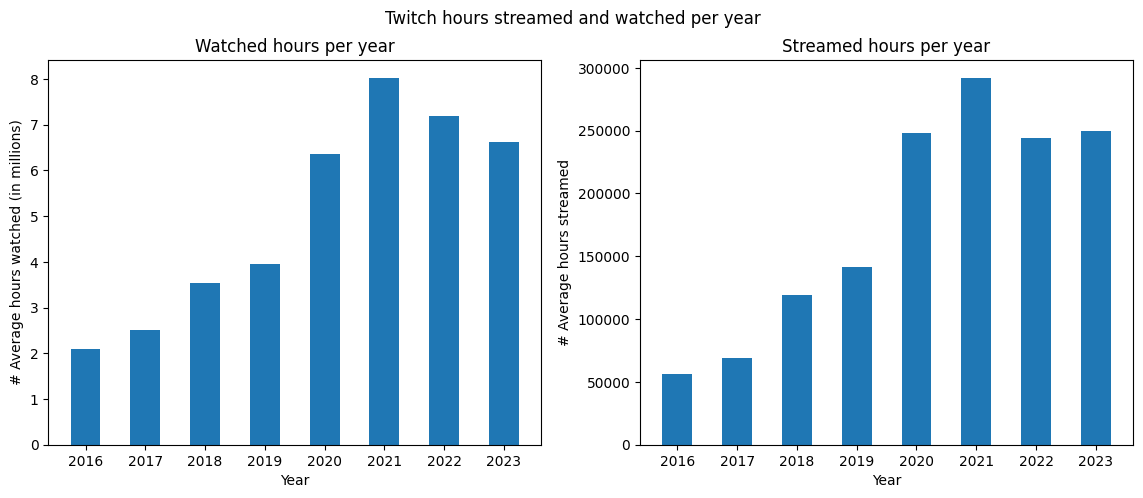

In [10]:
# Get years and watched/streamed hours
df_plot5 = df_tg[['Year', 'Hours_watched', 'Hours_streamed']]

# Group by year and get mean of watched/streamed hours
df_plot5 = df_plot5.groupby('Year').agg({
    'Hours_watched': 'mean',
    'Hours_streamed': 'mean'
})

# Convert watched hours in smaller values for better plot
df_plot5['Hours_watched'] = df_plot5['Hours_watched'] / 1000000

# Build plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Twitch hours streamed and watched per year")

# Plot 1 for watched hours per year
ax1.set_title("Watched hours per year")
ax1.bar(df_plot5.index[::-1], df_plot5['Hours_watched'].values[::-1], width=0.5)
ax1.set_xlabel('Year')
ax1.set_ylabel('# Average hours watched (in millions)')

# Plot 2 for streamed hours per year
ax2.set_title("Streamed hours per year")
ax2.bar(df_plot5.index[::-1], df_plot5['Hours_streamed'].values[::-1], width=0.5)
ax2.set_xlabel('Year')
ax2.set_ylabel('# Average hours streamed')

# Show plot
plt.show()

##### Video game genres on by hours watched

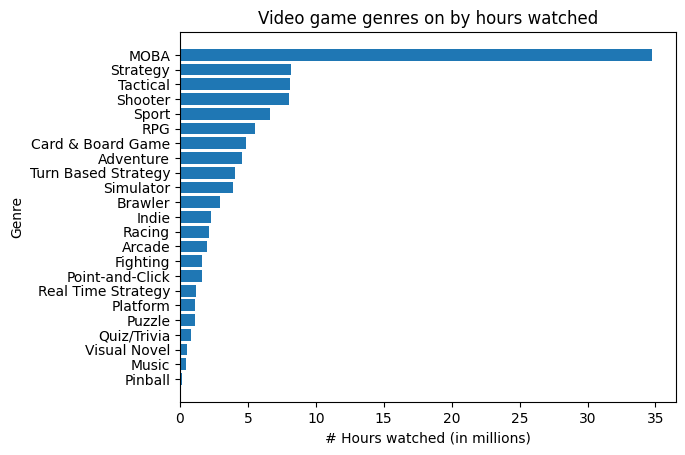

In [11]:
# Get years and watched/streamed hours
df_plot6 = df_merged[['Hours_watched', 'Genres']]
# Drop rows with NaN
df_plot6 = df_plot6.dropna()
# Convert values to list for usage with explode
df_plot6['Genres'] = df_plot6['Genres'].apply(lambda x: x.split(', '))
# Split values in single rows
df_plot6 = df_plot6.explode('Genres')

# Group genres, calculate average watched hours and sort appearances
df_plot6 = df_plot6.groupby('Genres').mean()
df_plot6 = df_plot6.sort_values('Hours_watched', ascending=False)

# Convert watched hours in smaller values for better plot
df_plot6['Hours_watched'] = df_plot6['Hours_watched'] / 1000000

# Build plot
plt.title("Video game genres on by hours watched")
plt.xlabel('# Hours watched (in millions)')
plt.ylabel('Genre')
plt.barh(df_plot6.index[::-1], df_plot6['Hours_watched'].values[::-1])

# Show plot
plt.show()

##### Average watched hours on Twitch per year by genre

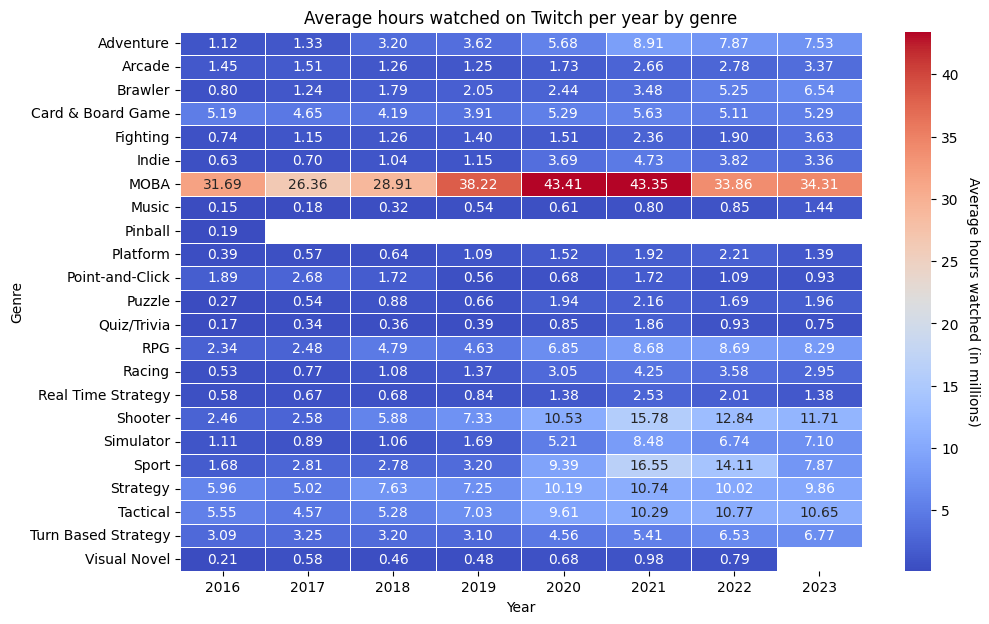

In [12]:
# Get years, genres, watched hours
df_plot7 = df_merged[['Year', 'Hours_watched', 'Genres']]
# Drop rows with NaN
df_plot7 = df_plot7.dropna()
# Convert values to list for usage with explode
df_plot7['Genres'] = df_plot7['Genres'].apply(lambda x: x.split(', '))
# Split values in single rows
df_plot7 = df_plot7.explode('Genres')
# Rename Genres to Genre (for plot)
df_plot7 = df_plot7.rename({'Genres': 'Genre'}, axis='columns')

# Group genres, calculate average watched hours and sort appearances
df_plot7 = df_plot7.groupby(['Genre', 'Year']).mean()

# Convert watched hours in smaller values for better plot
df_plot7['Hours_watched'] = df_plot7['Hours_watched'] / 1000000

# Unstack MultiIndex to get DataFrame with genres and years as rows
df_plot7 = df_plot7['Hours_watched'].unstack()

# Build plot
plt.figure(figsize=(11, 7))
plt.title("Average hours watched on Twitch per year by genre")

# Create Heatmap
heatmap = sns.heatmap(df_plot7, cmap="coolwarm", annot=True, fmt=".2f", linewidths=.5)
colorbar = heatmap.collections[0].colorbar
colorbar.set_label("Average hours watched (in millions)", rotation=270, labelpad=15)

# Show plot
plt.show()

##### Development of hours watched per year from 2016 per genre

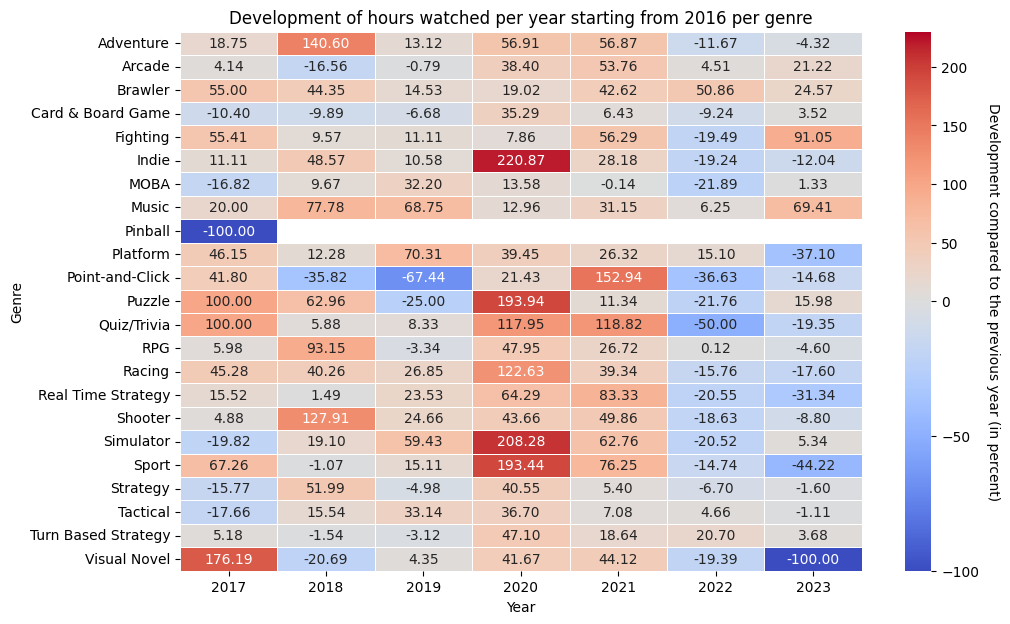

In [13]:
# Get years, genres, watched hours
df_plot8 = df_merged[['Year', 'Hours_watched', 'Genres']]
# Drop rows with NaN
df_plot8 = df_plot8.dropna()
# Convert values to list for usage with explode
df_plot8['Genres'] = df_plot8['Genres'].apply(lambda x: x.split(', '))
# Split values in single rows
df_plot8 = df_plot8.explode('Genres')
# Rename Genres to Genre (for plot)
df_plot8 = df_plot8.rename({'Genres': 'Genre'}, axis='columns')

# Group genres, calculate average watched hours and sort appearances
df_plot8 = df_plot8.groupby(['Genre', 'Year']).mean()

# Convert hours watched to use the same conditions as the previous plot
df_plot8['Hours_watched'] = df_plot8['Hours_watched'] / 1000000
df_plot8['Hours_watched'] = df_plot8['Hours_watched'].round(2)

# Unstack MultiIndex to get DataFrame with genres and years as rows
df_plot8 = df_plot8['Hours_watched'].unstack()

# Fill NaN with zero
df_plot8 = df_plot8.fillna(0)

# Calculate percentage change from previous to next year
df_plot8 = df_plot8.pct_change(axis=1, fill_method=None) * 100

# Drop column 2016 because it has no values (starter column for year development)
df_plot8 = df_plot8.drop(2016, axis=1)

# Build plot
plt.figure(figsize=(11, 7))
plt.title("Development of hours watched per year starting from 2016 per genre")

# Create Heatmap
divnorm=colors.TwoSlopeNorm(vmin=-100., vcenter=0., vmax=230)
heatmap = sns.heatmap(df_plot8, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5, norm=divnorm)
colorbar = heatmap.collections[0].colorbar
colorbar.set_label("Development compared to the previous year (in percent)", rotation=270, labelpad=15)

# Show plot
plt.show()

##### Share of each genre in hours watched per year

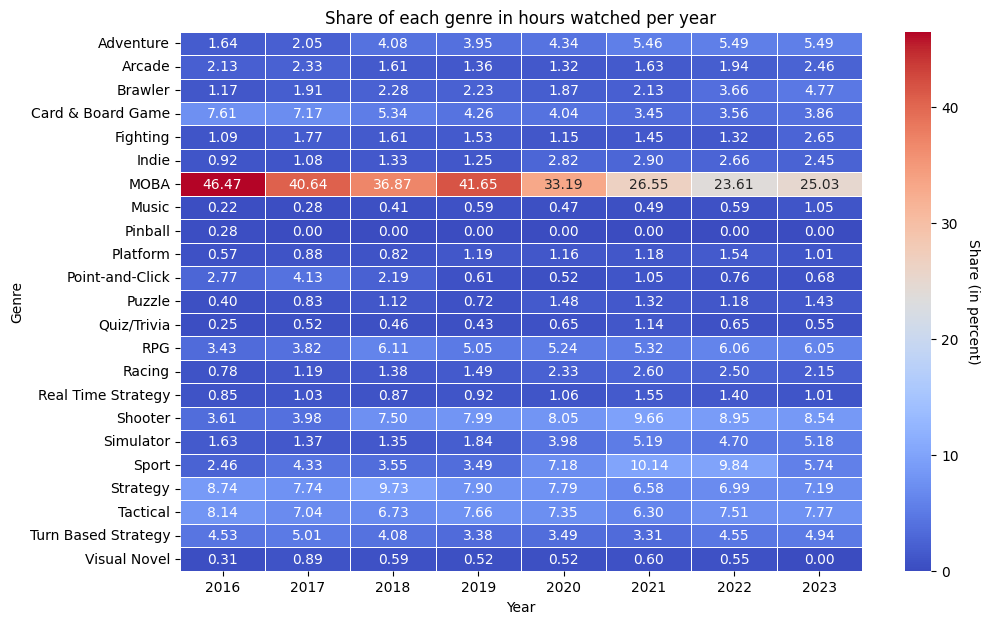

In [14]:
# Get years, genres, watched hours
df_plot9 = df_merged[['Year', 'Hours_watched', 'Genres']]
# Drop rows with NaN
df_plot9 = df_plot9.dropna()

# Convert values to list for usage with explode
df_plot9['Genres'] = df_plot9['Genres'].apply(lambda x: x.split(', '))
# Split values in single rows
df_plot9 = df_plot9.explode('Genres')
# Rename Genres to Genre (for plot)
df_plot9 = df_plot9.rename({'Genres': 'Genre'}, axis='columns')

# Group genres, calculate average watched hours and sort appearances
df_plot9 = df_plot9.groupby(['Genre', 'Year']).mean()

# Convert hours watched to use the same conditions as the previous plot
df_plot9['Hours_watched'] = df_plot9['Hours_watched'] / 1000000
df_plot9['Hours_watched'] = df_plot9['Hours_watched'].round(2)

# Unstack MultiIndex to get DataFrame with genres and years as rows
df_plot9 = df_plot9['Hours_watched'].unstack()

# Fill NaN with zero
df_plot9 = df_plot9.fillna(0)

# Calculate percentage of total watched hours for each genre in each year
df_plot9 = df_plot9.divide(df_plot9.sum(axis=0), axis=1) * 100

# Build plot
plt.figure(figsize=(11, 7))
plt.title("Share of each genre in hours watched per year")

# Create Heatmap
heatmap = sns.heatmap(df_plot9, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
colorbar = heatmap.collections[0].colorbar
colorbar.set_label("Share (in percent)", rotation=270, labelpad=15)

# Show plot
plt.show()

##### Development of share of the individual genres from 2016 to 2023

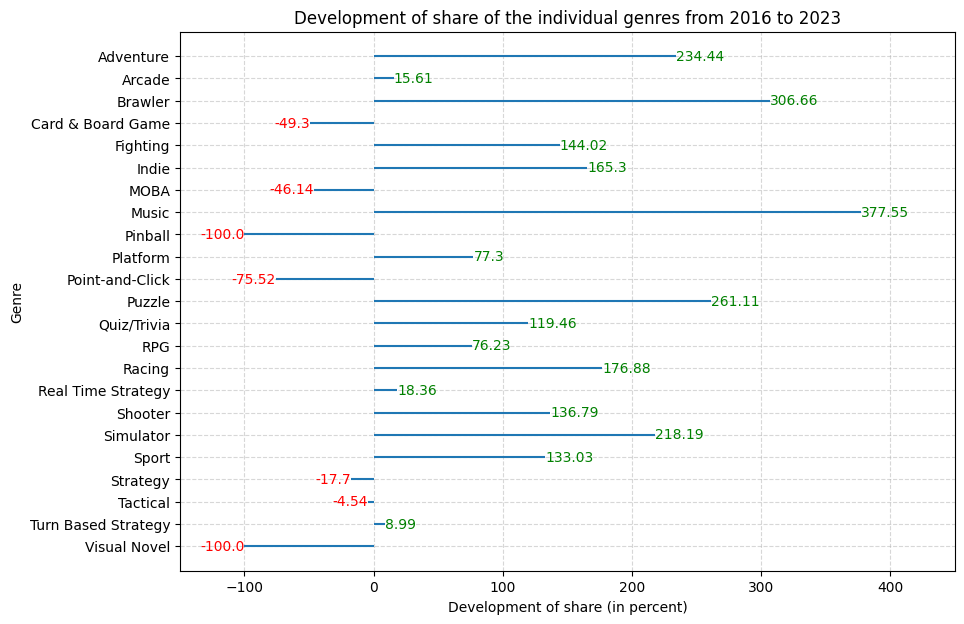

In [15]:
# Get years, genres, watched hours
df_plot10 = df_merged[['Year', 'Hours_watched', 'Genres']]
# Drop rows with NaN
df_plot10 = df_plot10.dropna()

# Get all possible years
years = df_plot10['Year'].unique()
# Create list with first and last year
years = [years[0], years[-1]]
# Filter rows that are not in these years
df_plot10 = df_plot10[df_plot10['Year'].isin(years)]

# Convert values to list for usage with explode
df_plot10['Genres'] = df_plot10['Genres'].apply(lambda x: x.split(', '))
# Split values in single rows
df_plot10 = df_plot10.explode('Genres')
# Rename Genres to Genre (for plot)
df_plot10 = df_plot10.rename({'Genres': 'Genre'}, axis='columns')

# Group genres, calculate average watched hours and sort appearances
df_plot10 = df_plot10.groupby(['Genre', 'Year']).mean()

# Convert hours watched to use the same conditions as the previous plot
df_plot10['Hours_watched'] = df_plot10['Hours_watched'] / 1000000
df_plot10['Hours_watched'] = df_plot10['Hours_watched'].round(2)

# Unstack MultiIndex to get DataFrame with genres and years as rows
df_plot10 = df_plot10['Hours_watched'].unstack()

# Fill NaN with zero
df_plot10 = df_plot10.fillna(0)

# Calculate percentage of total watched hours for each genre in each year
df_plot10 = df_plot10.divide(df_plot10.sum(axis=0), axis=1)

# Calculate percentage change from first to last year
df_plot10 = df_plot10.pct_change(axis=1, fill_method=None) * 100

# Drop column 2016 because it has no values (starter column for year development)
df_plot10 = df_plot10.drop(2016, axis=1)

# Build plot
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title("Development of share of the individual genres from 2016 to 2023")
ax.grid(linestyle='--', alpha=0.5)
ax.set_xlabel("Development of share (in percent)")
ax.set_xlim(-150, 450)
ax.set_ylabel("Genre")

# Plot lines
ax.hlines(y=df_plot10.index[::-1], xmin=0, xmax=df_plot10.values[::-1])

# Annotate lines
for genre, value in zip(df_plot10.index, df_plot10.values):
    ax.text(value, genre, round(value[0], 2), 
            horizontalalignment='right' if value < 0 else 'left', 
            verticalalignment='center', 
            fontdict={'color':'red' if value < 0 else 'green', 'size':10})

# Show plot
plt.show()

### Discussion/Conclusions

#### Interpretation

In essence, the results indicate that the genres with the most video games are similar to the genres played by gamers. Adventure ranks first in both releases and player preferences, making it the most popular. However, when it comes to players and hours watched on Twitch, the results show a complete difference between the top 10 most played and most watched games.

Even with a generalization of hours watched by genres, it becomes evident that people generally play different games than they watch on Twitch. Highly popular games are significantly dominated by the Adventure genre, while on Twitch, the MOBA genre is the most preferred to watch by a wide margin. Thus, in relation to the question posed in the Introduction, it can be generally stated that popular video games are not necessarily popular livestream formats.

However, further analyses have shown that both watched and streamed hours have increased over the years, which means that a purely absolute view of the hours watched does not reflect the real development on Twitch. An annual genre development on Twitch shows that although MOBA has the highest absolute watched hours, other genres like Indie, Simulator, and Sports had a much larger increase, especially in 2020. Relative shares of each genre in the total watched hours confirm that MOBA lost 20% of its share from 2016 to 2023. To complete the analysis, the development of genre shares from 2016 to 2023 was examined, revealing that MOBA has significantly lost popularity while other genres have become much more popular. Adventure, fittingly, is among the genres that have seen the most growth, aligning with its position as the most played video games genre, where Adventure holds the top spot.

In conclusion, the question posed in the Introduction cannot be definitively answered because there is no clear correlation between the most played and most watched games. Nevertheless, the Twitch development shows that some widely played genres now also have a significantly larger share of hours watched on Twitch.

#### Limitations

Although both data sources are of high quality, there are nevertheless limitations that complicate or prevent the conclusion of hypotheses.

One limitation in Data Source 2 is that players (column: Plays) are recorded only once, making annual analyses impossible and generally complicating the understanding of the relationship between a game's popularity and hours watched. Typically, video games are particularly popular upon release, and this popularity decreases over time. The same applies to streams. However, since there is no extensive data on current players per month, such a comparison cannot be conducted. Another issue is that the plays come from Backloggd, an external site where users register and manually maintain their game lists. Apart from errors when, for example, someone forgets to enter their game, there is also the problem that not every player uses Backloggd, potentially making the values non-representative.

In general, there is also the restriction that games are counted multiple times in the results if they have several genres, which may distort the results.

#### Future Work

This project provides a good insight into the most popular genres of video games. However, as mentioned in the limitations, more extensive data would be helpful to more precisely answer whether there are correlations between popularly played and watched video games. Other methods, such as monthly WebScraping from Backloggd, could be employed to extract players who are still playing the game in a given month, providing a more nuanced understanding instead of relying solely on the general plays of a video game.

Alternatively, the generalization of video games could also be conducted through other factors, such as the platforms on which the video games were released or the publisher that released the video game. More complex analyses could explore how video games develops after their release.

In essence, research in this area is interesting because the results can be utilized to estimate whether a video game set for future release might attain a certain level of popularity on Twitch. With more comprehensive data available, it could also reveal connections between players and viewers.